### *Data Analysis*
##  LDA on the aggregate 
---
*conducted in April 2022*

In [112]:
# Import necessary libraries
import nltk, re, pprint
import json
from nltk import word_tokenize
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import nltk.data
import os.path 
import glob
import pandas as pd
import os
import re
from nltk.corpus import PlaintextCorpusReader 
from nltk.app import concordance
from nltk.corpus import BracketParseCorpusReader
import numpy as np
import contractions
import statsmodels.formula.api as smf
import altair as alt
import tmtoolkit
import spacy as spacy
import logging, warnings
from tmtoolkit.corpus import Corpus
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
nltk.download('omw-1.4')
import pickle
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis
import pyLDAvis.gensim_models
import docx


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/charlottekaiser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---
### 1. Load in dataframe and pre-process
---

In [113]:
# Open prepared dataframe
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis')
with open('raw_corpus_aggregate.csv') as f:
    corpus = pd.read_csv(f)
f.close()
corpus.drop('Unnamed: 0', axis=1, inplace=True)
df = corpus[['eu', 'debate', 'text']]

# Data from text column to list
data = df.text.values.tolist()

# Remove single quotes and slashes
data = [re.sub("\'", "", sent) for sent in data]

# Clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))


In [114]:
# Prerequisites: stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
# Add sample specific stop words that are redundant and have no substantial relevance; also add words that are project-specific stopwords
stopwords.add('president')
stopwords.add('mr.')
stopwords.add('mrs.')
stopwords.add('ms.')
stopwords.add('mr')
stopwords.add('mrs')
stopwords.add('ms')
stopwords.add('commission')
stopwords.add('congress')
stopwords.add('speaker')
stopwords.add('also')
stopwords.add('artificial')
stopwords.add('intelligence')
stopwords.add('digital')
stopwords.add('ai')
stopwords.add('pro')
stopwords.add('tempore')
stopwords.add('representative')
stopwords.add('thank')
stopwords.add('dear')
stopwords.add('rapporteur')
stopwords.add('lady')
stopwords.add('committee')
stopwords.add('report')
stopwords.add('legislation')
stopwords.add('like')
stopwords.add('subcommittee')
stopwords.add('gentleman')
stopwords.add('r')
stopwords.add('colleague')
stopwords.add('madam')
stopwords.add('ha')
stopwords.add('wa')
stopwords.add('for')
stopwords.add('in')
stopwords.add('-')
stopwords.add(',')
stopwords.add('and')
stopwords.add('house')
stopwords.add('chairwoman')
stopwords.add('agency')
stopwords.add('sponsor')
stopwords.add('gentlewoman')
stopwords.add('verts')
stopwords.add('renew')
stopwords.add('bill')
stopwords.add('datum')
stopwords.add('year')
stopwords.add('amendment')
stopwords.add('president')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/charlottekaiser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [116]:
# Define functions for pre-processing: stopwords, create bigrams, lemmatization
## Lemmatization gets the root, for ref, see: https://spacy.io/api/annotation
def rm_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [117]:
# Remove Stop Words
words_nostops = rm_stopwords(data_words)

# Form Bigrams
words_bigrams = bigrams(words_nostops)

# Initialize spacy 'en' model
nlp = spacy.load("en_core_web_sm")

# Lemmatize, keep noun, adj, vb, adv
ready_corpus = lemmatize(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(ready_corpus[:1])

[['recent', 'week', 'show', 'even', 'robust', 'democratic', 'structure', 'safe', 'damage', 'happen', 'side', 'atlantic', 'inform', 'democratic', 'society', 'immune', 'harmful', 'influence', 'hate_speech', 'disinformation', 'fake_news', 'incitement', 'violence', 'event', 'shed', 'light', 'increase', 'importance', 'online', 'platform', 'social_media', 'company', 'shape', 'public', 'debate', 'highlighted', 'grow', 'interconnection', 'exist', 'transformation', 'democracy', 'prioritie', 'portuguese', 'presidency', 'unquestionable', 'social_media', 'company', 'status', 'public', 'square', 'mean', 'come', 'enhance', 'citizen', 'participation', 'ensure', 'freedom', 'expression', 'nevertheless', 'freedom', 'expression', 'absolute', 'balanced', 'goal', 'combat', 'illegal', 'incitement', 'violence', 'radicalisation', 'online', 'offline', 'illegal', 'illegal', 'online', 'online', 'platform', 'repeatedly', 'criticise', 'lack', 'transparency', 'use', 'algorithm', 'content', 'moderation', 'target', '

---
### 2. Build LDA model
---

In [118]:
# Create Dictionary
id2word = corpora.Dictionary(ready_corpus)

# Create Corpus
texts = ready_corpus

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Term Document Frequency (TDF)
corpus = [id2word.doc2bow(text) for text in texts]

# TDF readable for humans
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abascal', 1),
  ('abdicate', 1),
  ('able', 6),
  ('abolish', 1),
  ('abolition', 1),
  ('absence', 1),
  ('absolute', 2),
  ('absolutely', 1),
  ('abuse', 6),
  ('abused', 1),
  ('abusive', 1),
  ('accept', 9),
  ('acceptable', 1),
  ('access', 13),
  ('accordance', 2),
  ('accordingly', 2),
  ('account', 17),
  ('accountability', 5),
  ('accountable', 2),
  ('accusation', 1),
  ('achieve', 1),
  ('acknowledge', 1),
  ('acquaintance', 1),
  ('act', 28),
  ('acting', 1),
  ('action', 15),
  ('action_plan', 1),
  ('active', 3),
  ('activist', 3),
  ('activity', 3),
  ('actor', 8),
  ('actual', 1),
  ('actually', 5),
  ('ad', 4),
  ('adapt', 2),
  ('add', 4),
  ('addition', 2),
  ('additional', 1),
  ('address', 5),
  ('addressing', 1),
  ('adequate', 4),
  ('adequately', 1),
  ('adopt', 5),
  ('adoption', 1),
  ('advantage', 3),
  ('adversarie', 1),
  ('adversary', 1),
  ('advertise', 1),
  ('advertisement', 1),
  ('advertiser', 3),
  ('advertising', 6),
  ('advise', 1),
  ('affect'

---
#### 2.1 Run simple LDA model

In [119]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print out topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.001*"need" + 0.001*"go" + 0.000*"say" + 0.000*"technology"')
(1, '0.013*"datum" + 0.012*"technology" + 0.012*"use" + 0.011*"european"')
(2, '0.001*"support" + 0.001*"work" + 0.001*"use" + 0.001*"need"')
(3, '0.001*"technology" + 0.001*"use" + 0.001*"make" + 0.001*"need"')
(4, '0.000*"need" + 0.000*"technology" + 0.000*"woman" + 0.000*"go"')
(5, '0.001*"need" + 0.001*"make" + 0.001*"go" + 0.001*"technology"')
(6, '0.020*"area" + 0.014*"technology" + 0.014*"development" + 0.014*"radar"')
(7, '0.016*"education" + 0.013*"office" + 0.010*"technology" + 0.007*"cultural"')
(8, '0.010*"trade" + 0.009*"work" + 0.008*"technology" + 0.008*"important"')
(9, '0.001*"work" + 0.001*"need" + 0.001*"time" + 0.001*"technology"')
(10, '0.015*"freedom" + 0.013*"platform" + 0.011*"democracy" + 0.008*"online"')
(11, '0.001*"work" + 0.001*"military" + 0.001*"support" + 0.001*"make"')
(12, '0.026*"science" + 0.015*"support" + 0.015*"research" + 0.013*"technology"')
(13, '0.001*"technology" + 0.001*"mak

In [120]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=ready_corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.672490932384166

Coherence Score:  0.3428729836632093


In [121]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.126051 -0.078888       1        1  26.874729
14     0.134964 -0.074265       2        1  25.354380
1      0.186443  0.045095       3        1  12.632798
10     0.140558  0.153115       4        1  10.893715
8      0.150395  0.000387       5        1  10.666876
19     0.130088  0.147406       6        1   4.335214
18     0.128984 -0.025488       7        1   3.596008
12     0.117314 -0.164224       8        1   2.957475
7      0.068921 -0.032600       9        1   2.245381
6     -0.074323 -0.032373      10        1   0.437534
3     -0.088064  0.009479      11        1   0.000633
5     -0.102574  0.005667      12        1   0.000602
13    -0.112384  0.010115      13        1   0.000592
9     -0.099138  0.005899      14        1   0.000591
2     -0.113606  0.004885      15        1   0.000583
16    -0.115064  0.002417      16        1   0.000580
17    -0.123181  0.005723      17        1   0.000580
0     -0.116426  0.006193      18        1   0.000580
11    -0.110195  0.003755      19        1   0.000578
4     -0.128763  0.007702      20        1   0.000573, topic_info=            Term        Freq       Total Category  logprob  loglift
3725    military  333.000000  333.000000  Default  30.0000  30.0000
1736  technology  415.000000  415.000000  Default  29.0000  29.0000
2486     defense  216.000000  216.000000  Default  28.0000  28.0000
1925       woman  200.000000  200.000000  Default  27.0000  27.0000
1701     support  371.000000  371.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1754       think    0.000101  259.979654  Topic20  -8.2461  -2.6882
3285        stem    0.000091   69.206350  Topic20  -8.3559  -1.4745
2055    research    0.000100  234.265616  Topic20  -8.2596  -2.5975
795         good    0.000099  223.912955  Topic20  -8.2676  -2.5604
1931       world    0.000100  250.177550  Topic20  -8.2616  -2.6653

[1414 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3085      7  0.760300       abortion
2644      3  0.909946  accessibility
5241      8  0.907524     accountant
4110      1  0.089726     accounting
4110      8  0.897262     accounting
...     ...       ...            ...
1941      2  0.332543          young
1941      3  0.147797          young
1941      4  0.110848          young
1941      5  0.073899          young
1941      7  0.258645          young

[2168 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 15, 2, 11, 9, 20, 19, 13, 8, 7, 4, 6, 14, 10, 3, 17, 18, 1, 12, 5])

---
#### 2.2 Run more mature Mallet model

In [168]:
# Download: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
path_mallet = '/Users/charlottekaiser/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(path_mallet, corpus=corpus, num_topics=20, id2word=id2word)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 15918
total tokens: 58499
<10> LL/token: -9.02523
<20> LL/token: -8.62293
<30> LL/token: -8.47829
<40> LL/token: -8.40833

0	2.5	research development future page office science time leader program funding party today national advance scientific investment great competitive plan lead 
1	2.5	support technology product safety consumer act datum yield time establish urge ensure direct work introduce include technological blockchain agency material 
2	2.5	long problem life create give day action ensure year decide question begin state war term number covid goal grow lead 
3	2.5	american country world people year act government spend talk colleague budget effort united_state percent chinese back study senator chinese_communist nuclear 
4	2.5	education ensure change impact field development culture group essential play strengthen role skill school improve develop student reality framework clear 
5	2.5	increase forc

In [170]:
# Print out topics
topics = ldamallet.print_topics(num_words=4)
for topic in topics:
    print(topic)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=ready_corpus, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

(0, '0.064*"research" + 0.055*"science" + 0.046*"technology" + 0.042*"energy"')
(1, '0.032*"product" + 0.029*"safety" + 0.029*"consumer" + 0.028*"act"')
(2, '0.025*"good" + 0.025*"state" + 0.022*"create" + 0.020*"call"')
(3, '0.044*"people" + 0.040*"american" + 0.032*"world" + 0.028*"government"')
(4, '0.054*"education" + 0.043*"technology" + 0.037*"sector" + 0.028*"skill"')
(5, '0.048*"support" + 0.044*"include" + 0.028*"ensure" + 0.027*"time"')
(6, '0.053*"work" + 0.041*"make" + 0.022*"issue" + 0.021*"technology"')
(7, '0.081*"military" + 0.049*"defense" + 0.022*"ndaa" + 0.022*"department"')
(8, '0.052*"support" + 0.047*"member" + 0.047*"important" + 0.028*"work"')
(9, '0.026*"company" + 0.021*"political" + 0.020*"decision" + 0.019*"clear"')
(10, '0.034*"semiconductor" + 0.027*"global" + 0.027*"manufacturing" + 0.024*"chip"')
(11, '0.046*"freedom" + 0.044*"platform" + 0.039*"democracy" + 0.030*"online"')
(12, '0.033*"european" + 0.022*"system" + 0.022*"fundamental_right" + 0.019*"rul

---
#### 2.3 Find coherence scores for LDA models with different number of topics and identify most coherent model

In [180]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(path_mallet, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [181]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=ready_corpus, start=2, limit=40, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 15918
total tokens: 58499
<10> LL/token: -8.29903
<20> LL/token: -8.11999
<30> LL/token: -8.07654
<40> LL/token: -8.05845

0	25	technology datum european work woman freedom ensure important company rule protect platform citizen make time future state democracy public education 
1	25	support military make work research time people defense investment country include world thing year act american increase innovation continue program 

<50> LL/token: -8.04583
<60> LL/token: -8.03549
<70> LL/token: -8.02887
<80> LL/token: -8.02056
<90> LL/token: -8.02567

0	25	technology datum european work freedom woman make important rule protect platform ensure citizen future time democracy public company education clear 
1	25	support military work make research time defense people investment country include act innovation thing world year american technology today continue 

<100> LL/token: -8.02129
<110> LL/token: -8.01659
<120> 

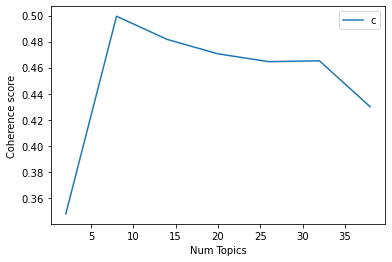

In [182]:
# Visualize 
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
# Save as file
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_aggregate')
plt.savefig('coherence-check.png')

In [183]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3476
Num Topics = 8  has Coherence Value of 0.4995
Num Topics = 14  has Coherence Value of 0.4817
Num Topics = 20  has Coherence Value of 0.4706
Num Topics = 26  has Coherence Value of 0.4646
Num Topics = 32  has Coherence Value of 0.4653
Num Topics = 38  has Coherence Value of 0.4299


---
#### 2.4 Run LDA Mallet model that is most coherent as per step 2.3

In [184]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

# Print out topics
topics = optimal_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.039*"military" + 0.030*"support" + 0.027*"defense" + 0.013*"department" + 0.012*"include" + 0.011*"require" + 0.011*"threat" + 0.009*"capability" + 0.009*"bipartisan" + 0.009*"pass"')
(1, '0.031*"datum" + 0.031*"european" + 0.027*"technology" + 0.016*"consumer" + 0.011*"protection" + 0.011*"citizen" + 0.011*"human" + 0.011*"development" + 0.011*"innovation" + 0.010*"protect"')
(2, '0.030*"freedom" + 0.026*"platform" + 0.022*"democracy" + 0.018*"democratic" + 0.017*"public" + 0.015*"online" + 0.014*"rule" + 0.013*"expression" + 0.013*"citizen" + 0.012*"political"')
(3, '0.031*"people" + 0.030*"make" + 0.019*"thing" + 0.018*"world" + 0.017*"year" + 0.014*"give" + 0.012*"talk" + 0.012*"call" + 0.012*"put" + 0.011*"today"')
(4, '0.030*"time" + 0.027*"work" + 0.015*"important" + 0.015*"increase" + 0.014*"ensure" + 0.013*"good" + 0.012*"member" + 0.011*"continue" + 0.011*"include" + 0.011*"country"')
(5, '0.023*"research" + 0.019*"innovation" + 0.017*"investment" + 0.016*"american" + 

In [198]:
# Store prevalence scores of all topics across documents (i.e. debates)
prev = optimal_model[corpus[0]]
prev1 = optimal_model[corpus[1]]
prev2 = optimal_model[corpus[2]]
prev3 = optimal_model[corpus[3]]
prev4 = optimal_model[corpus[4]]
prev5 = optimal_model[corpus[5]]
prev6 = optimal_model[corpus[6]]
prev7 = optimal_model[corpus[7]]
prev8 = optimal_model[corpus[8]]
prev9 = optimal_model[corpus[9]]
prev10 = optimal_model[corpus[10]]
prev11 = optimal_model[corpus[11]]
prev12 = optimal_model[corpus[12]]
prev13 = optimal_model[corpus[13]]
prev14 = optimal_model[corpus[14]]
prev15 = optimal_model[corpus[15]]
prev16 = optimal_model[corpus[16]]
prev17 = optimal_model[corpus[17]]
prev18 = optimal_model[corpus[18]]

In [199]:
prev_score = [prev, prev1, prev2, prev3, prev4, prev5, prev6, prev7, prev8, prev9, prev10, prev11, prev12, prev13, prev14, prev15, prev16, prev17, prev18]

In [215]:
# Find topic most dominant for each debate
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=ready_corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=ready_corpus)

# Format
df_topics_aggregate = df_topic_sents_keywords.reset_index()
df_topics_aggregate.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


/var/folders/h9/g02cmrsn6y571zb1v96gs56c0000gn/T/ipykernel_98291/3150705356.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/h9/g02cmrsn6y571zb1v96gs56c0000gn/T/ipykernel_98291/3150705356.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [216]:
# Add indicator variables for EU (1=EU; 0=US) and debate titles
eu = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
debate_title = ["EU02_Democratic scrutiny of social media and the protection of fundamental rights.txt", "EU03_European strategy for data - Commission evaluation report on the implementation of the General Data Protection Regulation two years after its application.txt",
"EU11_Digital Europe programme.txt", 
"EU13_Artificial intelligence in education, culture and the audiovisual sector.txt", 
"EU14_Digital future of Europe- digital single market and use of AI for European consumers.txt",
"EU15_ Promoting gender equality in science, technology, engineering and mathematics - STEM - education and careers.txt",
"EU18_Artificial intelligence in criminal law and its use by the police and judicial authorities in criminal matters.txt", 
"EU21_The outcome of the EU-US Trade and Technology Council.txt", 
"US02_CONSUMER SAFETY TECHNOLOGY ACT.txt", 
"US04_FEDERAL CAREER OPPORTUNITIES IN COMPUTER SCIENCE WORK ACT.txt", 
"US06_75th ANNIVERSARY OF THE OFFICE OF NAVAL RESEARCH.txt",
"US09_MSI STEM ACHIEVEMENT ACT.txt", 
"US10_National Defense Authorization Act.txt", 
"US15_FUTURE OF RADAR.txt", "US16_DEPARTMENT OF ENERGY SCIENCE FOR THE FUTURE ACT.txt",
"US18_STATEMENTS ON INTRODUCED BILLS AND JOINT RESOLUTIONS.txt", 
"US20_INTRODUCTION OF THE TRANSATLANTIC TELECOMMUNICATIONS SECURITY ACT.txt",
"US32_NATIONAL PULSE MEMORIAL.txt", 
"US37_ENDLESS FRONTIER ACT.txt"]

Keywords = [('0.030*"freedom" + 0.026*"platform" + 0.022*"democracy" + 0.018*"democratic" + 0.017*"public" + 0.015*"online" + 0.014*"rule" + 0.013*"expression" + 0.013*"citizen" + 0.012*"political"'),
('0.031*"datum" + 0.031*"european" + 0.027*"technology" + 0.016*"consumer" + 0.011*"protection" + 0.011*"citizen" + 0.011*"human" + 0.011*"development" + 0.011*"innovation" + 0.010*"protect"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.031*"datum" + 0.031*"european" + 0.027*"technology" + 0.016*"consumer" + 0.011*"protection" + 0.011*"citizen" + 0.011*"human" + 0.011*"development" + 0.011*"innovation" + 0.010*"protect"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.031*"datum" + 0.031*"european" + 0.027*"technology" + 0.016*"consumer" + 0.011*"protection" + 0.011*"citizen" + 0.011*"human" + 0.011*"development" + 0.011*"innovation" + 0.010*"protect"'),
('0.020*"work" + 0.019*"make" + 0.016*"important" + 0.014*"trade" + 0.014*"set" + 0.013*"world" + 0.013*"market" + 0.013*"economy" + 0.013*"future" + 0.012*"challenge"'),
('0.031*"datum" + 0.031*"european" + 0.027*"technology" + 0.016*"consumer" + 0.011*"protection" + 0.011*"citizen" + 0.011*"human" + 0.011*"development" + 0.011*"innovation" + 0.010*"protect"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.039*"military" + 0.030*"support" + 0.027*"defense" + 0.013*"department" + 0.012*"include" + 0.011*"require" + 0.011*"threat" + 0.009*"capability" + 0.009*"bipartisan" + 0.009*"pass"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.023*"research" + 0.019*"innovation" + 0.017*"investment" + 0.016*"american" + 0.016*"percent" + 0.013*"technology" + 0.012*"science" + 0.011*"government" + 0.010*"development" + 0.010*"united_state"'),
('0.036*"woman" + 0.023*"technology" + 0.022*"education" + 0.014*"future" + 0.014*"sector" + 0.014*"support" + 0.013*"area" + 0.011*"field" + 0.011*"skill" + 0.011*"science"'),
('0.039*"military" + 0.030*"support" + 0.027*"defense" + 0.013*"department" + 0.012*"include" + 0.011*"require" + 0.011*"threat" + 0.009*"capability" + 0.009*"bipartisan" + 0.009*"pass"'),
('0.039*"military" + 0.030*"support" + 0.027*"defense" + 0.013*"department" + 0.012*"include" + 0.011*"require" + 0.011*"threat" + 0.009*"capability" + 0.009*"bipartisan" + 0.009*"pass"'),
('0.023*"research" + 0.019*"innovation" + 0.017*"investment" + 0.016*"american" + 0.016*"percent" + 0.013*"technology" + 0.012*"science" + 0.011*"government" + 0.010*"development" + 0.010*"united_state"')]


df_topics_aggregate["EU"] = eu
df_topics_aggregate["debate_title"] = debate_title
df_topics_aggregate["prevalenc_of_topics"] = prev_score
topic_name = ['7 - Democracy', '6 - Citizens rights online', '8 - AI education','8 - AI education', '6 - Citizens rights online', '8 - AI education',
'6 - Citizens rights online', '5 - Global market', '6 - Citizens rights online', '8 - AI education', '8 - AI education', '8 - AI education', '3 - Military defense', '8 - AI education',
'4 - Domestic U.S. economy', '8 - AI education', '3 - Military defense', '3 - Military defense','4 - Domestic U.S. economy']
df_topics_aggregate["Dominant_Topic"] = topic_name
df_topics_aggregate["Keywords"] = Keywords

In [217]:
df_topics_aggregate

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,EU,debate_title,prevalenc_of_topics
0,0,7 - Democracy,0.5294,"0.030*""freedom"" + 0.026*""platform"" + 0.022*""de...","[recent, week, show, even, robust, democratic,...",1,EU02_Democratic scrutiny of social media and t...,"[(0, 0.00513989797495749), (1, 0.0918955359749..."
1,1,6 - Citizens rights online,0.3496,"0.031*""datum"" + 0.031*""european"" + 0.027*""tech...","[indeed, pandemic, accelerate, digitalisation,...",1,EU03_European strategy for data - Commission e...,"[(0, 0.016366366366366368), (1, 0.352942942942..."
2,2,8 - AI education,0.2721,"0.036*""woman"" + 0.023*""technology"" + 0.022*""ed...","[valter, flego, reporter, honorable, commissio...",1,EU11_Digital Europe programme.txt,"[(0, 0.011444978632478633), (1, 0.154340277777..."
3,3,8 - AI education,0.3420,"0.036*""woman"" + 0.023*""technology"" + 0.022*""ed...","[commissioner, colleague, first, even, late, h...",1,"EU13_Artificial intelligence in education, cul...","[(0, 0.006723184895348115), (1, 0.228821191230..."
4,4,6 - Citizens rights online,0.3652,"0.031*""datum"" + 0.031*""european"" + 0.027*""tech...","[deirdre, clune, shape, future, remove, barrie...",1,EU14_Digital future of Europe- digital single ...,"[(0, 0.004271926946631671), (1, 0.365273676727..."
5,5,8 - AI education,0.5590,"0.036*""woman"" + 0.023*""technology"" + 0.022*""ed...","[perez, excite, present, european_parliament, ...",1,"EU15_ Promoting gender equality in science, te...","[(0, 0.005651210793938479), (1, 0.070948497205..."
6,6,6 - Citizens rights online,0.4894,"0.031*""datum"" + 0.031*""european"" + 0.027*""tech...","[vitanov, need, catch, technical, development,...",1,EU18_Artificial intelligence in criminal law a...,"[(0, 0.012450199203187254), (1, 0.487660469234..."
7,7,5 - Global market,0.5311,"0.020*""work"" + 0.019*""make"" + 0.016*""important...","[valdi, dombrovski, executive_vice, european, ...",1,EU21_The outcome of the EU-US Trade and Techno...,"[(0, 0.006443488491800868), (1, 0.097553128906..."
8,8,6 - Citizens rights online,0.4038,"0.031*""datum"" + 0.031*""european"" + 0.027*""tech...","[pallone, move, suspend, rule, pass, direct, c...",0,US02_CONSUMER SAFETY TECHNOLOGY ACT.txt,"[(0, 0.17654612159329142), (1, 0.4062106918238..."
9,9,8 - AI education,0.2804,"0.036*""woman"" + 0.023*""technology"" + 0.022*""ed...","[move, suspend, rule, pass, establish, occupat...",0,US04_FEDERAL CAREER OPPORTUNITIES IN COMPUTER ...,"[(0, 0.22180225581953444), (1, 0.0864530837532..."


In [218]:
# Save dataframe
df_topics_aggregate.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/LDA_mallet_aggregate.csv')  

In [226]:
# Create dataframe for table output for word
df_word = df_topics_aggregate.drop(['Text', 'prevalenc_of_topics', 'Document_No'], axis=1)

In [227]:
# Save to table in word
doc = docx.Document('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_aggregate/LDA-table-aggregate.docx')

t = doc.add_table(df_word.shape[0]+1, df_word.shape[1])

# add the header rows.
for j in range(df_word.shape[-1]):
    t.cell(0,j).text = df_word.columns[j]

# add the rest of the data frame
for i in range(df_word.shape[0]):
    for j in range(df_word.shape[-1]):
        t.cell(i+1,j).text = str(df_word.values[i,j])

# save the doc
doc.save('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_aggregate/LDA-table-aggregate.docx')


---
#### 2.5 Visualize LDA Mallet model ran in 2.4

In [186]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [187]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the i

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.051546 -0.274667       1        1  19.610355
3      0.153597  0.342399       2        1  15.997796
0     -0.231952  0.128893       3        1  13.475596
5     -0.257803 -0.063067       4        1  12.671975
7     -0.063933 -0.027132       5        1  11.403276
1      0.162702 -0.062128       6        1   9.838723
2      0.279039 -0.055207       7        1   8.805065
6     -0.093196  0.010908       8        1   8.197214, topic_info=             Term        Freq       Total Category  logprob  loglift
3725     military  383.000000  383.000000  Default  30.0000  30.0000
1763         time  400.000000  400.000000  Default  29.0000  29.0000
1928         work  505.000000  505.000000  Default  28.0000  28.0000
1079         make  488.000000  488.000000  Default  27.0000  27.0000
1281       people  358.000000  358.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1383      promote   34.687182   63.670133   Topic8  -5.0707   1.8940
2055     research   54.828126  285.789607   Topic8  -4.6129   0.8503
20        achieve   32.449299   52.188651   Topic8  -5.1374   2.0262
1231  opportunity   35.806123  113.655730   Topic8  -5.0390   1.3463
1107       member   38.044006  193.634878   Topic8  -4.9784   0.8741

[683 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1         6  0.871861   abdicate
4         8  0.893702  abolition
6         7  1.035610   absolute
9         7  0.863008     abused
10        7  0.863008    abusive
...     ...       ...        ...
1936      2  1.002747      wrong
1937      1  0.010526       year
1937      2  0.989434       year
3951      3  0.837894      yield
3951      4  0.167579      yield

[874 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 6, 8, 2, 3, 7])

In [204]:
os.chdir('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/20_results/10_analysis/LDA_aggregate')
pyLDAvis.save_html(vis, 'pyLDAvis.html')
pyLDAvis.save_json(vis, 'pyLDAvis.json')